<a href="https://colab.research.google.com/github/dineshb302/TERM2/blob/pushanb/MLUL_Product_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sklearn
sklearn.__version__

'1.5.dev0'

If the version is higher than 1.3 it is fine.

If version is less than 1.3 then HDBSCAN will not work, so run the following

In [4]:
#!pip uninstall sklearn -y

In [5]:
#!pip install Cython

In [6]:
#!pip install git+https://github.com/scikit-learn/scikit-learn.git

  Cloning https://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-ce8hzha_
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-ce8hzha_
  Resolved https://github.com/scikit-learn/scikit-learn.git to commit 678e3999eeaadcaaef523d1d0d2f52a25986d460
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-1.5.dev0-cp310-cp310-linux_x86_64.whl size=12038118 sha256=764fc6ba4d5c0e356bfa6a76f5ec1a40261c589bdf96f08521e7e47888e4457c
  Stored in directory: /tmp/pip-ephem-wheel-cache-gry1hif6/wheels/33/2b/30/4298ac7ddb8056b3147c83f8a77e3af5b64a2463871af52c96
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
## Imports for clustering and visualization
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN  ## in Version 1.3 of sklearn

In [5]:
## Imports for cluster evaluation
from yellowbrick.cluster import SilhouetteVisualizer

## Metric evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [6]:
## Read the Champo Carpets V1.csv dataset
data = 'https://raw.githubusercontent.com/dineshb302/TERM2/7143f5150720b80d83441c9939b6eca6214ef591/Champo%20Carpets%20V1.csv'
Champo = pd.read_csv(data)
#data_file = 'gdrive/My Drive/Champo Carpets V1.csv'
#Champo = pd.read_csv(data_file, encoding = 'UTF-8')
print("Shape: ",Champo.shape)
Champo.info()

Shape:  (13135, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderiD           13135 non-null  int64  
 1   Item_Id           13135 non-null  int64  
 2   CustomerCode      13135 non-null  object 
 3   CountryName       13135 non-null  object 
 4   customer_country  13135 non-null  object 
 5   QtyRequired       13135 non-null  int64  
 6   TotalArea         13135 non-null  float64
 7   Amount            13135 non-null  float64
 8   ITEM_NAME         13135 non-null  object 
 9   QualityName       13135 non-null  object 
 10  DesignName        13135 non-null  object 
 11  ColorName         13135 non-null  object 
 12  ShapeName         13135 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.3+ MB


Data has no Null values.

In [7]:
Champo.describe()

,OrderiD,Item_Id,QtyRequired,TotalArea,Amount
count,13135.000000,13135.000000,13135.000000,13135.000000,13135.000000
mean,3075.336962,14528.683746,44.460601,44.731370,2392.040164
std,2107.731646,13183.139544,228.749535,50.099597,16832.091080
min,1.000000,1.000000,1.000000,0.040000,0.000000
25%,1219.500000,3023.000000,3.000000,5.800000,163.200000
50%,2934.000000,8631.000000,8.000000,24.000000,590.625000
75%,4630.000000,26713.000000,20.000000,80.000000,1540.000000
max,7548.000000,46701.000000,6400.000000,1024.000000,599719.680000


Deriving the Quantity of each Item sold from the dataset

In [8]:
item_quantity = Champo.groupby(['Item_Id'])['QtyRequired'].sum().reset_index()
item_quantity.columns = ['Item_Id','TotalQuantity']
item_quantity[0:5]

,Item_Id,TotalQuantity
0,1,2
1,2,2
2,3,7
3,4,9
4,5,22


Deriving the Revenue earned by each Item and the %share of Revenue it holds from the dataset

In [22]:
Total_Amount = Champo['Amount'].sum()
item_revenue = Champo.groupby(['Item_Id'])['Amount'].sum().reset_index()
item_revenue['Share'] = (item_revenue['Amount']/Total_Amount)*100
item_revenue.columns = ['Item_Id', 'TotalRevenue', 'ItemShare']
item_revenue[0:5]

,Item_Id,TotalRevenue,ItemShare
0,1,12.00,0.000038
1,2,18.00,0.000057
2,3,378.00,0.001203
3,4,641.25,0.002041
4,5,2821.50,0.008980


Deriving the Number of customers bought each Item from the dataset

In [10]:
item_cust = Champo.groupby(['Item_Id'])['CustomerCode'].nunique().reset_index()
item_cust.columns = ['Item_Id', 'NumberofCustomer']
item_cust[0:5]

,Item_Id,NumberofCustomer
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


Deriving the Average Quantity of each Item sold  per order from the dataset

In [11]:
item_orders = Champo.groupby(['Item_Id'])['OrderiD'].nunique().reset_index()
item_orders.columns = ['Item_Id', 'NumberofOrder']
item_orders = item_orders.merge(item_quantity, on = 'Item_Id')
item_orders['AvgQty/Order'] = item_orders['TotalQuantity']/item_orders['NumberofOrder']
item_orders = item_orders.get(['Item_Id','AvgQty/Order'])
item_orders[0:5]

,Item_Id,AvgQty/Order
0,1,2.0
1,2,2.0
2,3,3.5
3,4,4.5
4,5,11.0


Deriving the Average Price at which each Item is sold

In [19]:
item_price = Champo.groupby(['Item_Id'])['Amount'].sum().reset_index()
item_price = item_price.merge(item_quantity, on='Item_Id')
item_price['AvgPrice'] = item_price['Amount']/item_price['TotalQuantity']
item_price = item_price.get(['Item_Id','AvgPrice'])
item_price[0:5]

,Item_Id,AvgPrice
0,1,6.00
1,2,9.00
2,3,54.00
3,4,71.25
4,5,128.25


Merging the individual DFs to get the Item DataFrame for the Item Segmentation.

In [121]:
Item_df = item_quantity.merge(item_revenue, on='Item_Id').merge(item_cust, on='Item_Id').merge(item_orders, on='Item_Id').merge(item_price, on='Item_Id')
Item_df.describe()

,Item_Id,TotalQuantity,TotalRevenue,ItemShare,NumberofCustomer,AvgQty/Order,AvgPrice
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,17618.831489,99.402553,5347.991072,0.017021,1.018213,54.491168,139.627252
std,13793.870179,410.559181,27198.829943,0.086567,0.136254,261.207924,403.681727
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,4970.500000,4.000000,180.000000,0.000573,1.000000,3.000000,12.750000
50%,14901.000000,15.000000,960.000000,0.003055,1.000000,9.333333,56.000000
75%,29742.500000,50.000000,2825.159000,0.008992,1.000000,25.000000,153.000000
max,46701.000000,9400.000000,605669.280000,1.927689,3.000000,6400.000000,10442.573793


Pairwise scatter Plot to identify any correlations (if any)

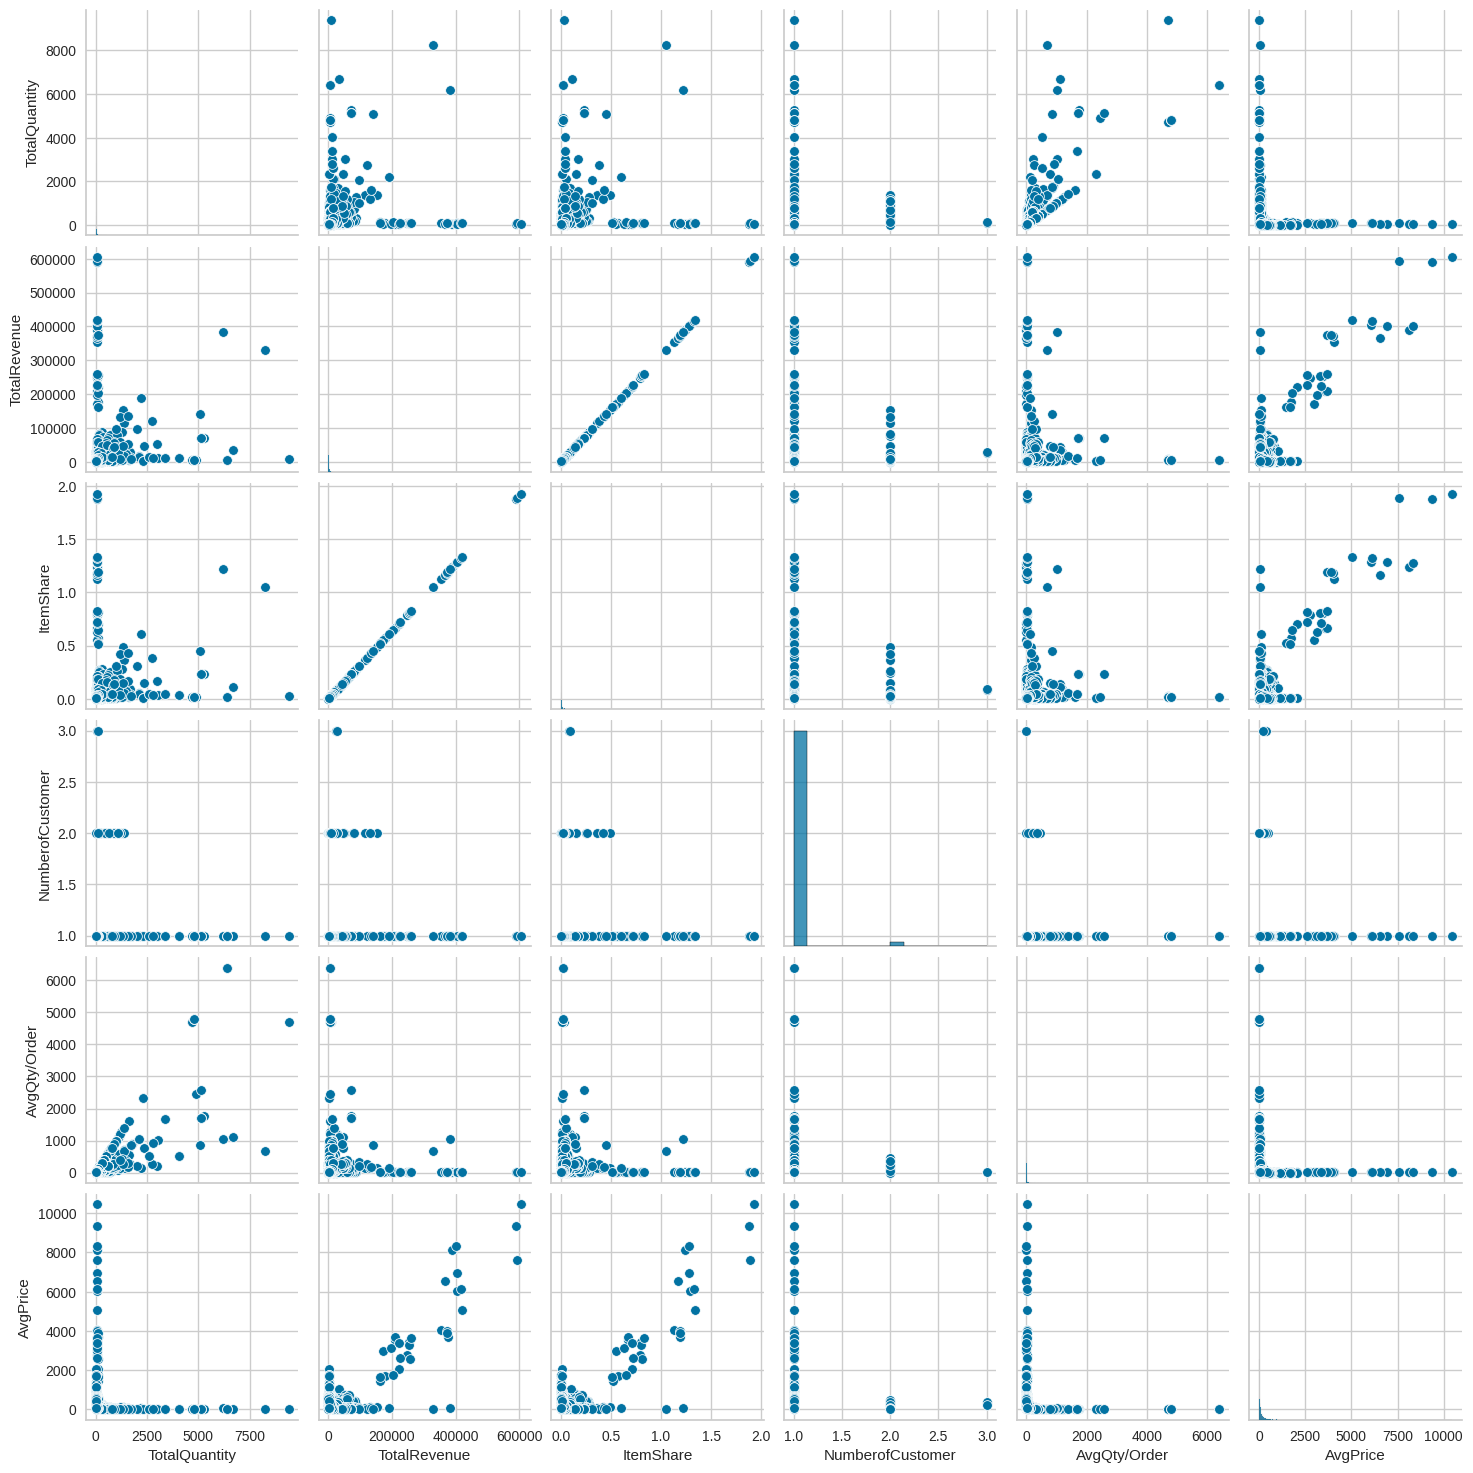

In [25]:
sn.pairplot(Item_df, kind='scatter', vars=['TotalQuantity','TotalRevenue','ItemShare','NumberofCustomer','AvgQty/Order','AvgPrice'])

On the basis of the scatter plot, we can conclude that few items can be dropped from analysis as we have good proxy for them in other features. Eg: Revenue is covered in ItemShare and similarly, Quantity and Orders are captured better in AvgQty/Order

In [31]:
Item_df = Item_df.get(['Item_Id','NumberofCustomer','ItemShare','AvgQty/Order','AvgPrice'])
print('Shape of Item_df is: ', Item_df.shape)
Item_df[0:5]

Shape of Item_df is:  (5875, 5)


,Item_Id,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice
0,1,1,0.000038,2.0,6.00
1,2,1,0.000057,2.0,9.00
2,3,1,0.001203,3.5,54.00
3,4,1,0.002041,4.5,71.25
4,5,1,0.008980,11.0,128.25


Standard Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_scale_item_df = scaler.fit_transform( Item_df[['NumberofCustomer',
                                                   'ItemShare',
                                                   'AvgQty/Order',
                                                   'AvgPrice']] )

In [39]:
std_scale_item_df = pd.DataFrame(std_scale_cust_df,
                                 columns = ['NumberofCustomer',
                                            'ItemShare',
                                            'AvgQty/Order',
                                            'AvgPrice'])
std_scale_item_df[0:5]

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice
0,-0.133679,-0.196201,-0.200973,-0.331049
1,-0.133679,-0.195981,-0.200973,-0.323617
2,-0.133679,-0.182744,-0.195230,-0.212134
3,-0.133679,-0.173064,-0.191401,-0.169398
4,-0.133679,-0.092898,-0.166514,-0.028186


Min-Max Scaling

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
min_max_scale_item_df = scaler.fit_transform( Item_df[['NumberofCustomer',
                                                       'ItemShare',
                                                       'AvgQty/Order',
                                                       'AvgPrice']] )

In [41]:
min_max_scale_item_df = pd.DataFrame(min_max_scale_cust_df,
                                     columns = ['NumberofCustomer',
                                                'ItemShare',
                                                'AvgQty/Order',
                                                'AvgPrice'] )
min_max_scale_item_df[0:5]

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice
0,0.0,0.000020,0.000156,0.000575
1,0.0,0.000030,0.000156,0.000862
2,0.0,0.000624,0.000391,0.005171
3,0.0,0.001059,0.000547,0.006823
4,0.0,0.004658,0.001563,0.012281


Clustering with Scaled DataFrame

In [122]:
## We can proceed with either the Standard Scaled dataframe or the Min-Max Scaled DataFrame
## So use either std_scale_item_df or min_max_scale_item_df as the scale_item_df

scale_item_df = min_max_scale_item_df      ## Based on analysis and trying out all 3 options, we find Min-Max scaled data gives better results

## For no scaling use
#scale_item_df = Item_df

In [123]:
cluster_df = scale_item_df.get(['NumberofCustomer','ItemShare','AvgQty/Order','AvgPrice'])
cluster_df.describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice
count,5875.000000,5875.000000,5875.000000,5875.000000
mean,0.009106,0.008830,0.008359,0.013371
std,0.068127,0.044907,0.040820,0.038657
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000297,0.000313,0.001221
50%,0.000000,0.001585,0.001302,0.005363
75%,0.000000,0.004665,0.003751,0.014652
max,1.000000,1.000000,1.000000,1.000000


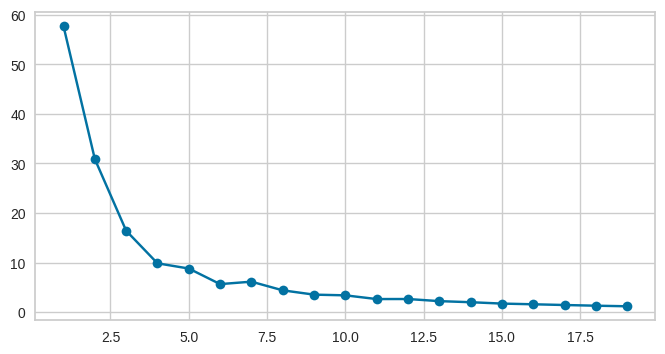

In [124]:
## KMEANS Clustering -- Elbow method
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  cluster_errors.append( clusters.inertia_ )

plt.figure(figsize=(8,4))
plt.plot( cluster_range, cluster_errors, marker = "o" );

Evaluating the cluster with k in (6,7,8,9,10,11)

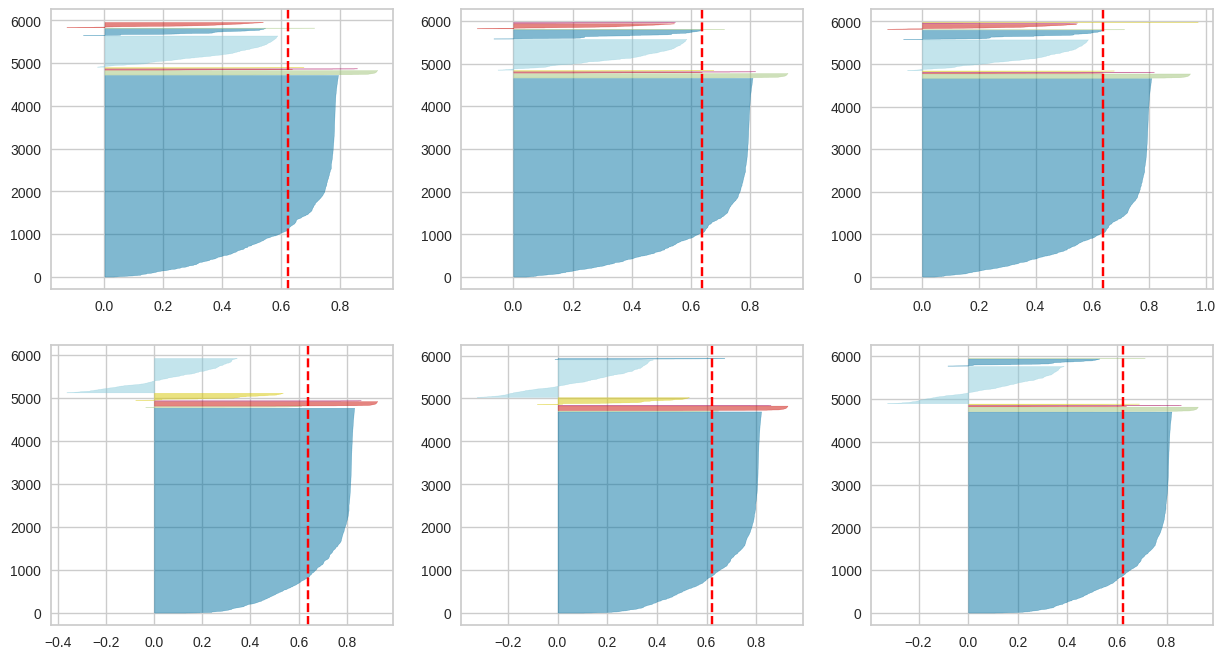

In [125]:
## Silhouette Visualization

fig, ax = plt.subplots(2, 3, figsize=(15,8))
num_clusters = [6,7,8,9,10,11]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k,
                random_state=42)
    q, mod = divmod(i, 3)
    visualizer = SilhouetteVisualizer(km,
                                      colors='yellowbrick',
                                      ax=ax[q-1][mod])
    visualizer.fit(cluster_df)

Creating 7 clusters since it has the low area in the negative part of the graph

In [138]:
k = 7

clusters = KMeans( k, random_state = 42 )
clusters.fit( cluster_df )


KMeans(n_clusters=7, random_state=42)

Understanding the clusters.

In [139]:
scale_item_df['clusterid'] = clusters.labels_

In [140]:
## Cluster 0
scale_item_df[scale_item_df['clusterid']==0].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,4689.0,4689.000000,4689.000000,4689.000000,4689.0
mean,0.0,0.002942,0.004064,0.006180,0.0
std,0.0,0.005323,0.008030,0.006265,0.0
min,0.0,0.000000,0.000000,0.000000,0.0
25%,0.0,0.000178,0.000417,0.000968,0.0
50%,0.0,0.001019,0.001406,0.004022,0.0
75%,0.0,0.003208,0.003751,0.009881,0.0
max,0.0,0.056288,0.056103,0.025971,0.0


Cluster 0 are the products that have a very low price wth very low orders, hence a low share in revenue. This constitute bulk of the products (approx 80%).

In [141]:
## Cluster 1
scale_item_df[scale_item_df['clusterid']==1].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,11.0,11.000000,11.000000,11.000000,11.0
mean,0.0,0.746673,0.001147,0.719359,1.0
std,0.0,0.153969,0.000217,0.150688,0.0
min,0.0,0.604692,0.000915,0.484169,1.0
25%,0.0,0.651767,0.000926,0.606535,1.0
50%,0.0,0.667686,0.001153,0.726759,1.0
75%,0.0,0.832729,0.001268,0.787552,1.0
max,0.0,1.000000,0.001585,1.000000,1.0


Cluster 1 are products which are very high priced but since they have low orders so controls the mid section when it comes to revenue. It is a very low populated cluster.

In [142]:
## Cluster 2
scale_item_df[scale_item_df['clusterid']==2].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,105.000000,105.000000,105.000000,105.000000,105.0
mean,0.509524,0.021867,0.008618,0.011943,2.0
std,0.068674,0.042744,0.014496,0.010354,0.0
min,0.500000,0.000040,0.000000,0.000076,2.0
25%,0.500000,0.002307,0.000313,0.004203,2.0
50%,0.500000,0.007400,0.000886,0.008957,2.0
75%,0.500000,0.019508,0.016018,0.017427,2.0
max,1.000000,0.254592,0.070167,0.046910,2.0


Cluster 2 are the products that have a low price wth low orders, hence a low share in revenue.

In [143]:
## Cluster 3
scale_item_df[scale_item_df['clusterid']==3].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,10.0,10.000000,10.000000,10.000000,10.0
mean,0.0,0.009982,0.818722,0.000103,3.0
std,0.0,0.002264,0.125280,0.000014,0.0
min,0.0,0.007760,0.734333,0.000092,3.0
25%,0.0,0.008297,0.734333,0.000093,3.0
50%,0.0,0.010038,0.749961,0.000096,3.0
75%,0.0,0.010171,0.937490,0.000114,3.0
max,0.0,0.015520,1.000000,0.000129,3.0


Cluster 3 are the products that have a very very low price wth high orders and low-moderate share in revenue.

In [144]:
## Cluster 4
scale_item_df[scale_item_df['clusterid']==4].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,165.0,165.000000,165.000000,165.000000,165.0
mean,0.0,0.019408,0.113405,0.001005,4.0
std,0.0,0.030813,0.067369,0.001134,0.0
min,0.0,0.002331,0.051935,0.000096,4.0
25%,0.0,0.004736,0.075246,0.000360,4.0
50%,0.0,0.010030,0.084909,0.000687,4.0
75%,0.0,0.020070,0.131114,0.001221,4.0
max,0.0,0.233105,0.400453,0.009193,4.0


Cluster 4 are the products that have a very low price wth moderate orders and moderate share in revenue.

In [145]:
## Cluster 5
scale_item_df[scale_item_df['clusterid']==5].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,872.0,872.000000,872.000000,872.000000,872.0
mean,0.0,0.016832,0.002206,0.039620,5.0
std,0.0,0.028841,0.006429,0.021803,0.0
min,0.0,0.000468,0.000000,0.001691,5.0
25%,0.0,0.001605,0.000156,0.027232,5.0
50%,0.0,0.003613,0.000313,0.034951,5.0
75%,0.0,0.016323,0.001118,0.046540,5.0
max,0.0,0.221249,0.048570,0.196503,5.0


Cluster 5 are the products that have a moderate price wth very low orders and low share in revenue.

In [146]:
## Cluster 6
scale_item_df[scale_item_df['clusterid']==6].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,23.0,23.000000,23.000000,23.000000,23.0
mean,0.0,0.417014,0.013781,0.247646,6.0
std,0.0,0.122516,0.039109,0.121748,0.0
min,0.0,0.266666,0.000868,0.003819,6.0
25%,0.0,0.330492,0.001222,0.167333,6.0
50%,0.0,0.373021,0.001372,0.284550,6.0
75%,0.0,0.485912,0.001596,0.344925,6.0
max,0.0,0.631827,0.161275,0.386372,6.0


Cluster 6 are the products that have a moderate price wth very low orders and good share in revenue.

In [147]:
## Cluster 7
scale_item_df[scale_item_df['clusterid']==7].describe()

,NumberofCustomer,ItemShare,AvgQty/Order,AvgPrice,clusterid
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


Lets validate ou understanding of the clusters with viloin plots of each feature per cluster

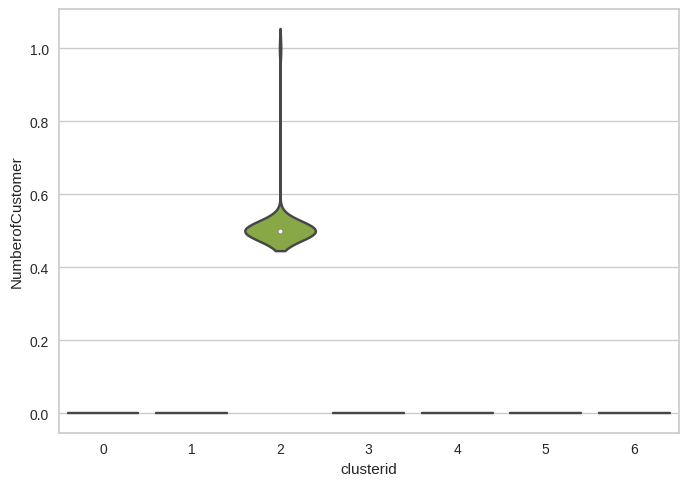

In [161]:
sn.violinplot(data = scale_item_df,
              y = 'NumberofCustomer',
              x = 'clusterid');

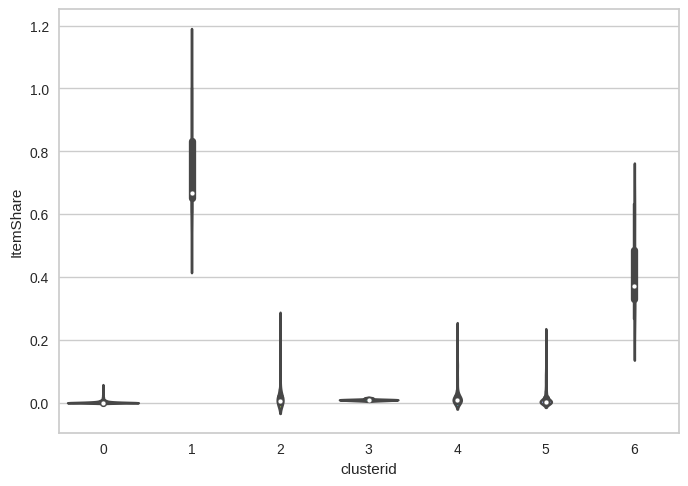

In [158]:
sn.violinplot(data = scale_item_df,
              y = 'ItemShare',
              x = 'clusterid');

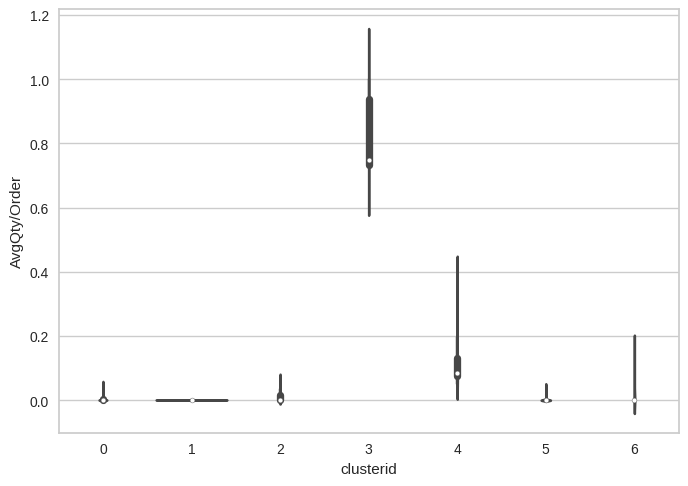

In [159]:
sn.violinplot(data = scale_item_df,
              y = 'AvgQty/Order',
              x = 'clusterid');

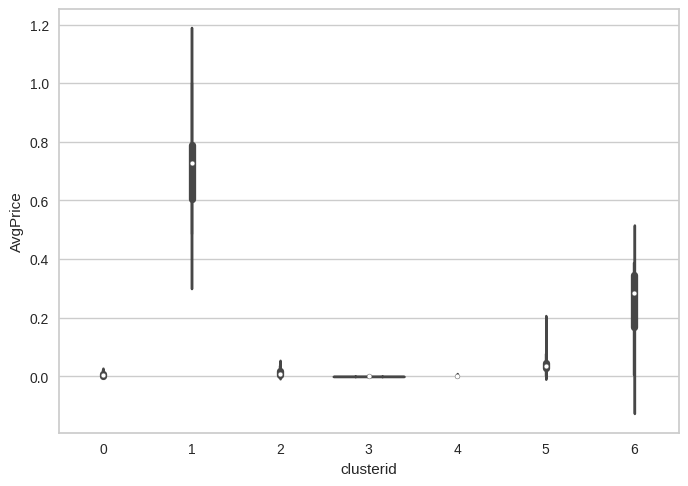

In [160]:
sn.violinplot(data = scale_item_df,
              y = 'AvgPrice',
              x = 'clusterid');

Evalauating the clusters

In [148]:
## Calinski-Harabasz Index => Relative measure (higher the value greater is the clustering performance)

cluster_range = range( 6, 12 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  print(f"n_cluster: {num_clusters} - CH Score: {calinski_harabasz_score(cluster_df, clusters.labels_)}" )

n_cluster: 6 - CH Score: 10780.267542043983
n_cluster: 7 - CH Score: 11011.26472063772
n_cluster: 8 - CH Score: 10309.618538912444
n_cluster: 9 - CH Score: 10255.924311294371
n_cluster: 10 - CH Score: 11019.843620365127
n_cluster: 11 - CH Score: 12189.224997604428


A CH score of 11011 wrt to other clusters shows that 7-clusters give a good outcome.

In [149]:
## Davies-Bouldin Index => lower value means better clustering

cluster_range = range( 6, 12 )
ch_scores = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( cluster_df )
  print(f"n_cluster: {num_clusters} - Davies-Bouldin Score: {davies_bouldin_score(cluster_df, clusters.labels_)}" )

n_cluster: 6 - Davies-Bouldin Score: 0.6631413001793146
n_cluster: 7 - Davies-Bouldin Score: 0.5520811458398248
n_cluster: 8 - Davies-Bouldin Score: 0.5945804292162967
n_cluster: 9 - Davies-Bouldin Score: 0.6191466170734609
n_cluster: 10 - Davies-Bouldin Score: 0.5608512655971583
n_cluster: 11 - Davies-Bouldin Score: 0.4988764773303323


A Davies-Bouldin score of 0.55 is a good score to have given the scores for other K values.

Hierarchical Clustering

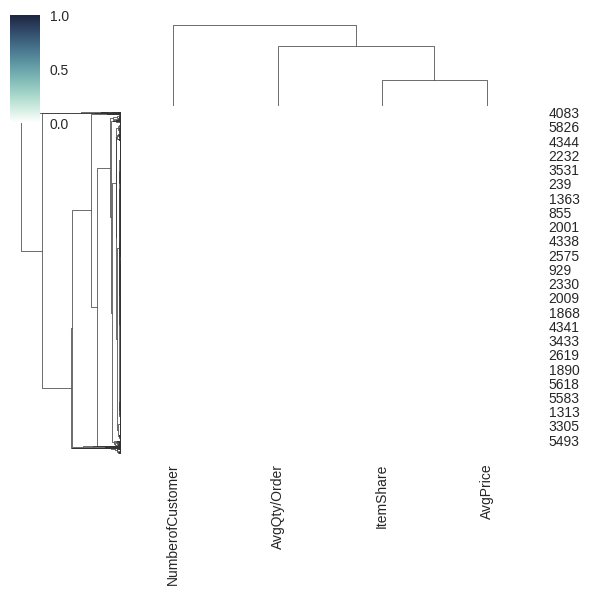

In [157]:
cmap = sn.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sn.clustermap(cluster_df,
              cmap=cmap,
              linewidths=.2,
              figsize = (6,6) );

In [151]:
## Agglomerative Clustering using euclidean

h_cluster = AgglomerativeClustering(n_clusters = 7,
                                    metric = 'euclidean',
                                    linkage = 'ward',           ## minimizes the variance of the clusters being merged
                                    compute_distances = True)

In [152]:
h_cluster.fit(cluster_df)

AgglomerativeClustering(compute_distances=True, n_clusters=7)

In [174]:
scale_item_df['hcluster_clusterid'] = h_cluster.labels_
#scale_item_df[0:5]
agglo_cluster = scale_item_df.groupby(['hcluster_clusterid'])['ItemShare'].count().reset_index()
print(agglo_cluster)

   hcluster_clusterid  ItemShare
0                   0        665
1                   1        105
2                   2         26
3                   3         10
4                   4         11
5                   5        123
6                   6       4935


Agglomerative gives clusters more or less of same size by Items

In [154]:
h_cluster.n_leaves_

5875

In [155]:
h_cluster.children_

array([[    0,    14],
       [    1,   474],
       [  673,  1082],
       ...,
       [11730, 11744],
       [11745, 11746],
       [11741, 11747]])

In [156]:
h_cluster.distances_

array([0.        , 0.        , 0.        , ..., 3.62780011, 5.22297181,
       7.3199357 ])

Density Based Clustering using HDBSCAN

In [162]:
## Need to set the min cluster size
hdbscan = HDBSCAN(min_cluster_size=2)

In [163]:
hdbscan.fit(cluster_df)

HDBSCAN(min_cluster_size=2)

In [164]:
hdbscan.labels_

array([1519, 1492,   -1, ...,   -1,  427,  785])

In [165]:
scale_item_df['hdbscan_clusterid'] = hdbscan.labels_

In [168]:
## See the cluster
print('Number of Clusters in HDBSCAN: ', scale_item_df['hdbscan_clusterid'].nunique())

Number of Clusters in HDBSCAN:  1533


This many clusters are not possible to interpret.